# Random Forest
- Author: Kimberly Yeo
- Module: Capstone
- Date: 16/2/2022

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import snscrape.modules.twitter as sntwitter
import nltk
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Load Bitcoin and Tweets data

In [2]:
final_df = pd.read_csv("tweets_bitcoin.csv")

## TFIDF

In [3]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(final_df['Text'])

In [4]:
df1 = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
final_df.drop('Text', axis=1, inplace=True)
final_df = pd.concat([final_df, df1], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
train = final_df[:-29].dropna()
test = final_df[-29:].dropna()

In [6]:
train.head()

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,zuckbuck,zuckerberg,zug,zulutrad,zurich,zytara,álvarez,ángel,ștefan,аre
0,2018-09-30,0.013610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-01,0.613488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-10-02,0.561735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,1.117252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Trial

In [7]:
rf_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
rf_model.fit(train[df1.columns], train["Obs_Vol"])

RandomForestRegressor(n_estimators=10, random_state=0)

In [8]:
y_pred = rf_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 20.692
MSE: 934.111


In [9]:
from sklearn.metrics import r2_score
r2_score(test["Obs_Vol"], y_pred)

-0.17755212583178182

## Create a 1-day lag for TFIDF

In [10]:
lag1_df = final_df.copy()

In [11]:
lag1_df = pd.concat([final_df["Date"], lag1_df.iloc[:,1:].shift(1)], axis=1)

## Create n-day lags for TFIDF

In [12]:
def get_lag_df(n_lag, final_df):
    lag_df = final_df.copy()
    lag_df = pd.concat([final_df[["Date", "Obs_Vol"]], lag_df.iloc[:,2:].shift(n_lag)], axis=1)
    return lag_df

In [13]:
lag_dict = {}
for i in range(1, 10):
    lag_dict["lag{}_df".format(i)] = get_lag_df(i, final_df).dropna()

In [14]:
# Lag tuning function which produces elbow plot
def lag_tuning(lag_dict, accur_metric):
    min_mae = 0
    min_mse = 0
    count = 1
    lag_score_df = pd.DataFrame(columns = ["lag", accur_metric])
    for k in lag_dict.keys():
        df = lag_dict[k]
        train = df[:-count].dropna()
        test = df[-count:].dropna()
        rf_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
        rf_model.fit(train[df1.columns], train["Obs_Vol"])
        y_pred = rf_model.predict(test[df1.columns])
        if accur_metric == "mae":
            mae = mean_absolute_error(test["Obs_Vol"], y_pred)
            if count == 0:
                min_mae = mae
                best_lag = k
            else:
                if min_mae > mae:
                    min_mae = mae
            lag_score_df = lag_score_df.append({"lag": count, accur_metric: mae}, ignore_index=True)
        elif accur_metric == "mse":
            mse = mean_squared_error(test["Obs_Vol"], y_pred)
            if count == 1:
                min_mse = mse
                best_lag = k
            else:
                if min_mse > mse:
                    min_mse = mse
            lag_score_df = lag_score_df.append({"lag": count+1, accur_metric: mse}, ignore_index=True)
        count += 1
    plt.plot(lag_score_df["lag"], lag_score_df[accur_metric], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel(accur_metric)
    plt.show()
    return lag_score_df

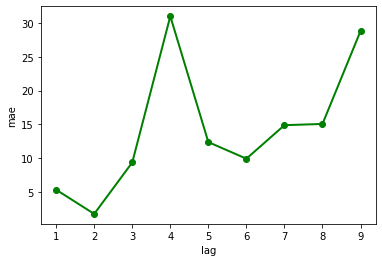

CPU times: user 4min 20s, sys: 516 ms, total: 4min 20s
Wall time: 7min 53s


,lag,mae
0,1.0,5.285116
1,2.0,1.701871
2,3.0,9.332704
3,4.0,31.012858
4,5.0,12.349259
5,6.0,9.888128
6,7.0,14.859893
7,8.0,15.043724
8,9.0,28.817379


In [15]:
%%time
lag_tuning(lag_dict, "mae")

In [16]:
# Choosing lag_6 as the best dataframe with 6-day lagged tfidf features
df = lag_dict["lag6_df"]

## Date specific feature engineering

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
df['Year'] = df['Date'].dt.year 
df['Month'] = df['Date'].dt.month 
df['Day'] = df['Date'].dt.day

df['dayofweek_num'] = df['Date'].dt.dayofweek  
# df['dayofweek_name']= df['Date'].dt.weekday_name

In [19]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,zurich,zytara,álvarez,ángel,ștefan,аre,Year,Month,Day,dayofweek_num
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,6,5
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,7,6
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,8,0
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,9,1
10,2018-10-10,1.211243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,24,4
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,25,5
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,26,6
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,27,0


## Lags for observed volatility

In [20]:
def get_lags(lag_start, lag_end, df):
    for i in range(lag_start, lag_end):
        df['lag_'+str(i)] = df.Obs_Vol.shift(i)
    return df

In [21]:
df = get_lags(1, 8, df)

In [22]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Month,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,6,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,7,6,0.572715,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,8,0,0.000346,0.572715,NaN,NaN,NaN,NaN,NaN
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,9,1,0.255549,0.000346,0.572715,NaN,NaN,NaN,NaN
10,2018-10-10,1.211243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,10,2,0.148203,0.255549,0.000346,0.572715,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766


## Rolling window for observed volatility

In [23]:
df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

In [24]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,0.572715,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0.000346,0.572715,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,0.255549,0.000346,0.572715,NaN,NaN,NaN,NaN,NaN
10,2018-10-10,1.211243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,2,0.148203,0.255549,0.000346,0.572715,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323,29.491320
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,29.016698
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,28.346478
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,16.107261


## Lag tuning for Random Forest

In [ ]:
lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
lag_model_dict = {}
for lag in lag_dict.keys():
    print(lag)
    df = lag_dict[lag]
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year 
    df['Month'] = df['Date'].dt.month 
    df['Day'] = df['Date'].dt.day
    df['dayofweek_num'] = df['Date'].dt.dayofweek
    
    df = get_lags(1, 8, df)
    df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()
    
    df = df.dropna()
    df1 = df.iloc[:, 3:]
    
    lag_no = int(lag[3])
    train = df[:-(lag_no)].dropna()
    test = df[-(lag_no):].dropna()
    
    rf_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    rf_model.fit(train[df1.columns], train["Obs_Vol"])
    
    lag_model_dict["model_lag{}".format(str(lag_no))] = rf_model.fit(train[df1.columns], train["Obs_Vol"])
    
    y_pred = rf_model.predict(test[df1.columns])
    mae = mean_absolute_error(test["Obs_Vol"], y_pred)
    mse = mean_squared_error(test["Obs_Vol"], y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    
    # Plotting estimated Random Forest volatility against actual volatility
    pred_vol = pd.DataFrame(y_pred)
    pred_vol.index = test['Date']
    pred_vol = pred_vol.rename(columns={0: "Volatility"})

    actual_vol = pd.DataFrame(test['Obs_Vol'])
    actual_vol.index = test['Date']

    # Plot the actual Bitcoin volatility
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

    # Plot Random Forest estimated volatility
    plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

    plt.legend(loc = 'upper right')
    plt.show()
    
    lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
plt.xlabel("lag")
plt.ylabel("mae")
plt.show()

## Hyperparameter tuning and lag tuning for Random Forest

In [33]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10]
            }

In [34]:
def rf_tuning(param_grid):
    model_dict = {}
    lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
    for lag in lag_dict.keys():
        print(lag)
        df = lag_dict[lag]

        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year 
        df['Month'] = df['Date'].dt.month 
        df['Day'] = df['Date'].dt.day
        df['dayofweek_num'] = df['Date'].dt.dayofweek

        df = get_lags(1, 8, df)
        df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

        df = df.dropna()
        df1 = df.iloc[:, 3:]

        lag_no = int(lag[3])
        train = df[:-(lag_no)].dropna()
        test = df[-(lag_no):].dropna()

        # Hyperparameter tuning
        n_folds = 5
        
        rf_model = GridSearchCV(RandomForestRegressor(),
                                    param_grid=param_grid,
                                    cv=KFold(n_splits=n_folds,
                                            shuffle=True),
                                     scoring="neg_mean_squared_error")
        rf_model.fit(train[df1.columns], train["Obs_Vol"])

        y_pred = rf_model.predict(test[df1.columns])
        mae = mean_absolute_error(test["Obs_Vol"], y_pred)
        mse = mean_squared_error(test["Obs_Vol"], y_pred)
        print('MAE: %.3f' % mae)
        print('MSE: %.3f' % mse)

        # Plotting estimated Random Forest volatility against actual volatility
        pred_vol = pd.DataFrame(y_pred)
        pred_vol.index = test['Date']
        pred_vol = pred_vol.rename(columns={0: "Volatility"})

        actual_vol = pd.DataFrame(test['Obs_Vol'])
        actual_vol.index = test['Date']

        # Plot the actual Bitcoin volatility
        # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

        # Plot Random Forest estimated volatility
        plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

        plt.legend(loc = 'upper right')
        plt.show()

        lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
    plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel("mae")
    plt.show()
    return model_dict, lag_score_df

lag1_df
MAE: 2.762
MSE: 7.630


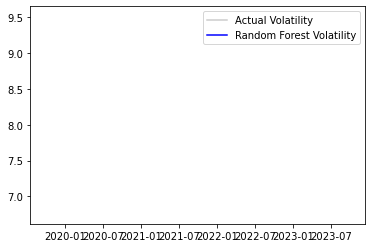

lag2_df
MAE: 16.900
MSE: 491.051


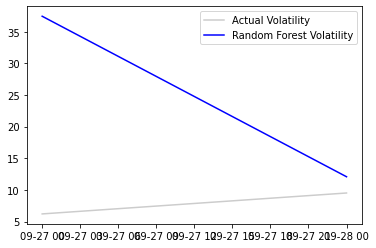

lag3_df
MAE: 30.003
MSE: 1397.626


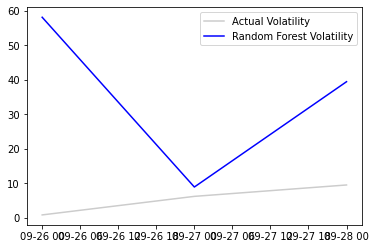

lag4_df
MAE: 18.473
MSE: 415.464


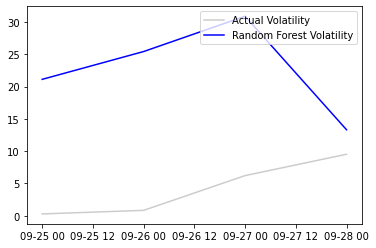

lag5_df
MAE: 27.582
MSE: 844.778


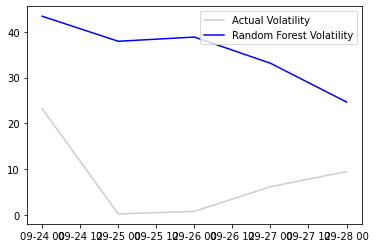

lag6_df


In [ ]:
%%time
model_dict, lag_score_df = rf_tuning(param_grid)

MAE: 23.375
MSE: 670.507


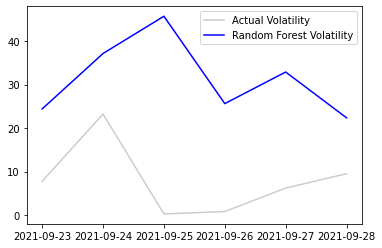

In [37]:
df = lag_dict["lag6_df"]

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year 
df['Month'] = df['Date'].dt.month 
df['Day'] = df['Date'].dt.day
df['dayofweek_num'] = df['Date'].dt.dayofweek

df = get_lags(1, 8, df)
df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

df = df.dropna()
df1 = df.iloc[:, 3:]

lag_no = int(lag[3])
train = df[:-6].dropna()
test = df[-6:].dropna()

# Hyperparameter tuning
n_folds = 5

rf_model = GridSearchCV(RandomForestRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                             scoring="neg_mean_squared_error")
rf_model.fit(train[df1.columns], train["Obs_Vol"])

y_pred = rf_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

# Plotting estimated Random Forest volatility against actual volatility
pred_vol = pd.DataFrame(y_pred)
pred_vol.index = test['Date']
pred_vol = pred_vol.rename(columns={0: "Volatility"})

actual_vol = pd.DataFrame(test['Obs_Vol'])
actual_vol.index = test['Date']

# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot Random Forest estimated volatility
plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

plt.legend(loc = 'upper right')
plt.show()